# Protected CRR
It would be interesting to contrast with ACI...

In [39]:
import os
n_cores = 5
os.environ["OMP_NUM_THREADS"] = str(n_cores)
os.environ["MKL_NUM_THREADS"] = str(n_cores)
os.environ["OPENBLAS_NUM_THREADS"] = str(n_cores)
os.environ["NUMEXPR_NUM_THREADS"] = str(n_cores)

import numpy as np
rnd_gen = np.random.default_rng(2024)
import matplotlib.pyplot as plt
from ucimlrepo import fetch_ucirepo 
from sklearn.model_selection import train_test_split
from online_cp import PluginMartingale
from scipy.optimize import brentq
from tqdm.notebook import tqdm
from online_cp import ConformalRidgeRegressor

def quantile(p, cdf_func):
# Invert CDF using root-finding (find x such that cdf(x) = p)
    return brentq(lambda x: cdf_func(x) - p, 0, 1)

rnd_gen = np.random.default_rng(2024)

In [40]:
# wine_quality = fetch_ucirepo(id=186) 
# wine = wine_quality.data.original

# X = wine.drop(columns=['quality', 'color']).values
# Y = wine['quality'].astype('float').values

# # TODO: Get initial training set.

# X = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))

# Generate data
X = rnd_gen.normal(loc=0, scale=1, size=(2000, 4))
beta1 = np.array([2, 1, 0, 0])
beta2 = np.array([0, -2,-1, 0])
beta3 = np.array([0, 0, 2, 1])
Y1 = X[:500] @ beta1 + rnd_gen.normal(loc=0, scale=1, size=500)
Y2 = X[500:1500] @ beta2 + rnd_gen.normal(loc=0, scale=1, size=1000)
Y3 = X[1500:] @ beta3 + rnd_gen.normal(loc=0, scale=1, size=500)
Y = np.concatenate([Y1, Y2, Y3])

In [41]:
def compute_p_value(y, precomputed):
    A = precomputed['A']
    B = precomputed['B']
    try:
        E = A + y*B

        Alpha = np.zeros_like(A)

        for i, e in enumerate(E):
            alpha = min((E >= e).sum(), (E<=e).sum())
            Alpha[i] = alpha

        alpha_y = Alpha[-1]
        leq = np.where(Alpha <= alpha_y)[0].shape[0]

        p_y = leq/Alpha.shape[0]
    except TypeError:
        p_y = rnd_gen.uniform(0, 1)
    return p_y

In [42]:
epsilon = 0.1

eps = epsilon
bounds = 'both'

cp = ConformalRidgeRegressor(0.1)


# Ensure that we can get informative prediction sets from the start
X_init_train = X[:int(np.ceil(2/epsilon))]
y_init_train = Y[:int(np.ceil(2/epsilon))]

X_process = X[int(np.ceil(2/epsilon)):]
y_process = Y[int(np.ceil(2/epsilon)):]

delta = 0.01
M = y_process.size
gamma_opt = (max(epsilon, 1-epsilon))/(delta*M - 1)
gamma = gamma_opt

cp.learn_initial_training_set(X_init_train, y_init_train)

martingale = PluginMartingale(warnings=False)

p_values = np.empty_like(y_process)
protected_p_values = np.empty_like(y_process)
aci_p_values = np.empty_like(y_process)

base_predictions = np.empty(shape=(y_process.shape[0], 2))
protected_predictions = np.empty(shape=(y_process.shape[0], 2))
aci_predictions = np.empty(shape=(y_process.shape[0], 2))

eps_array = np.empty_like(y_process)
epsilon_hat_array = np.empty_like(y_process)

Err = 0
err = 0


for i, (obj, lab) in tqdm(enumerate(zip(X_process, y_process)), total=y_process.size):

    # Base prediction
    Gamma, precomputed = cp.predict(obj, epsilon=epsilon, return_update=True, bounds=bounds)
    base_predictions[i, :] = Gamma

    # Protected prediction
    # Protected significance level
    func = lambda x: martingale.B_n(x) - epsilon
    epsilon_hat = brentq(func, 0, 1)

    protected_Gamma = cp.predict(obj, epsilon=epsilon_hat, bounds=bounds)
    protected_predictions[i, :] = protected_Gamma
    epsilon_hat_array[i] = epsilon_hat

    aci_Gamma = cp.predict(obj, epsilon=eps)
    aci_predictions[i, :] = aci_Gamma
    eps_array[i] = eps

    # Compute p-values
    p = cp.compute_p_value(x=obj, y=lab, precomputed=precomputed, bounds=bounds, smoothed=False)
    protected_p = martingale.B_n(p)
    aci_inv = lambda x: (x - eps + gamma*err) / gamma
    aci_p = aci_inv(p)

    martingale.update_martingale_value(p)

    p_values[i] = p
    protected_p_values[i] = protected_p
    aci_p_values[i] = aci_p

    # ACI update
    err = cp.err(aci_Gamma, lab)
    Err += err
    eps += gamma*(epsilon - err)

    cp.learn_one(obj, lab)

  0%|          | 0/1980 [00:00<?, ?it/s]

/home/johan/Documents/PhD/PREMACOP/OnlineConformalPrediction/src/online_cp/regressors.py:397: UserWarning: Significance level epsilon is too small for training set. Need at least -3759 examples. Increase or add more examples
  warnings.warn(f'Significance level epsilon is too small for training set. Need at least {int(np.ceil(2/epsilon))} examples. Increase or add more examples')
/home/johan/Documents/PhD/PREMACOP/OnlineConformalPrediction/src/online_cp/regressors.py:397: UserWarning: Significance level epsilon is too small for training set. Need at least -51 examples. Increase or add more examples
  warnings.warn(f'Significance level epsilon is too small for training set. Need at least {int(np.ceil(2/epsilon))} examples. Increase or add more examples')
/home/johan/Documents/PhD/PREMACOP/OnlineConformalPrediction/src/online_cp/regressors.py:397: UserWarning: Significance level epsilon is too small for training set. Need at least -58 examples. Increase or add more examples
  warnings.wa

In [43]:
(p_values <= epsilon).mean()

0.15858585858585858

In [44]:
(protected_p_values <= epsilon).mean()

0.10757575757575757

In [45]:
def winkler(intervals, true_values, alpha):
    # idx_informative = np.argwhere(intervals[:, 1] < np.inf).flatten()
    # intervals = intervals[idx_informative, :]
    # Define intervals and true values
    L = intervals[:, 0]  # Lower bounds
    U = intervals[:, 1]  # Upper bounds
    y = true_values#[idx_informative]      # True values

    # Compute components of Winkler score
    width = U - L  # Interval width
    below = L - y  # Difference when true value is below L
    above = y - U  # Difference when true value is above U

    # Compute Winkler score for each case
    winkler_score = np.where(
        y < L,  # Case 1: y < L
        width + (2 / alpha) * below,
        np.where(
            y > U,  # Case 3: y > U
            width + (2 / alpha) * above,
            width  # Case 2: L <= y <= U
        )
    )
    return winkler_score

def avg_width(intervals):
    idx_informative = np.argwhere(intervals[:, 1] < np.inf).flatten()
    intervals = intervals[idx_informative, :]
    return (intervals[:, 1] - intervals[:, 0]).mean()

/tmp/ipykernel_1741006/2454829930.py:17: RuntimeWarning: invalid value encountered in add
  width + (2 / alpha) * below,
/tmp/ipykernel_1741006/2454829930.py:20: RuntimeWarning: invalid value encountered in add
  width + (2 / alpha) * above,


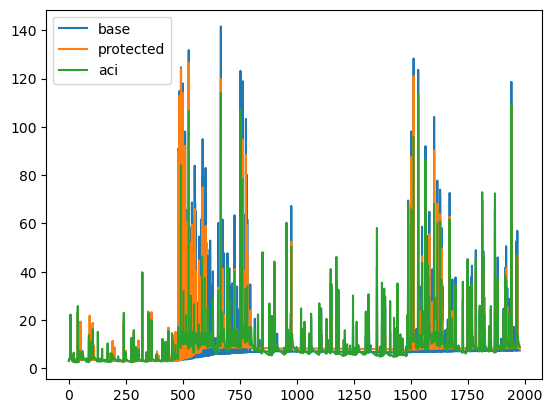

In [46]:
plt.plot(winkler(base_predictions, y_process, epsilon), label='base')

plt.plot(winkler(protected_predictions, y_process, epsilon), label='protected')

plt.plot(winkler(aci_predictions, y_process, epsilon), label='aci')

plt.legend()

Base

In [47]:
print('Base')
print(f'Error rate: {((base_predictions[:,0] > y_process) + (base_predictions[:, 1] < y_process)).astype(int).mean()}') #{(p_values <= epsilon).mean()}')
print(f'Winkler: {winkler(base_predictions, y_process, epsilon).sum()}')
print(f'Width: {avg_width(base_predictions)}')
print(f'Uninformative: {1-(base_predictions[:,1] < np.inf).mean()}')


Base
Error rate: 0.15858585858585858
Winkler: 19981.23707474306
Width: 5.8258178579844895
Uninformative: 0.0


Protected

In [48]:
print('Protected')
print(f'Error rate: {((protected_predictions[:,0] > y_process) + (protected_predictions[:, 1] < y_process)).astype(int).mean()}') #{(protected_p_values <= epsilon).mean()}')
print(f'Winkler: {winkler(protected_predictions, y_process, epsilon).sum()}')
print(f'Width: {avg_width(protected_predictions)}')
print(f'Uninformative: {1-(protected_predictions[:,1] < np.inf).mean()}')

Protected
Error rate: 0.10757575757575757
Winkler: 19175.741062511537
Width: 6.881184975090657
Uninformative: 0.0


ACI

In [49]:
print('ACI')
print(f'Error rate: {((aci_predictions[:,0] > y_process) + (aci_predictions[:, 1] < y_process)).astype(int).mean()}') #{Err/Y.shape[0]}')
print(f'Winkler: {winkler(aci_predictions, y_process, epsilon).sum()}')
print(f'Width: {avg_width(aci_predictions)}')
print(f'Uninformative: {1-(aci_predictions[:,1] < np.inf).mean()}')

ACI
Error rate: 0.1005050505050505
Winkler: inf
Width: 6.759878511476134
Uninformative: 0.06515151515151518


/tmp/ipykernel_1741006/2454829930.py:17: RuntimeWarning: invalid value encountered in add
  width + (2 / alpha) * below,
/tmp/ipykernel_1741006/2454829930.py:20: RuntimeWarning: invalid value encountered in add
  width + (2 / alpha) * above,


Text(0.5, 1.0, 'Protected CRR')

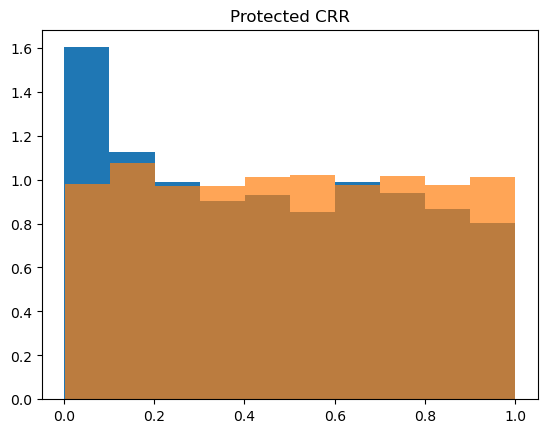

In [50]:
protected_p_values = martingale.B_n(p_values)
plt.hist(p_values, density=True)
plt.hist(protected_p_values, density=True, alpha=0.7)
plt.title('Protected CRR')

(array([0.01061829, 0.06207617, 0.05635863, 0.04655713, 0.04533194,
        0.04002279, 0.0492117 , 0.04308576, 0.03614303, 0.01490645]),
 array([-3.86289552, -1.38955745,  1.08378062,  3.55711869,  6.03045676,
         8.50379483, 10.9771329 , 13.45047097, 15.92380905, 18.39714712,
        20.87048519]),
 <BarContainer object of 10 artists>)

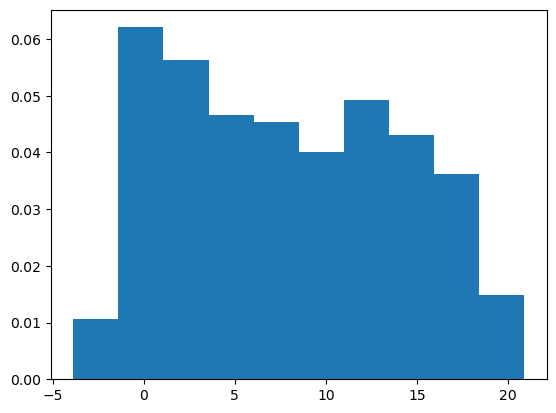

In [51]:
plt.hist(aci_p_values, density=True)

Text(0.5, 1.0, 'Approximate calibration plot CRR')

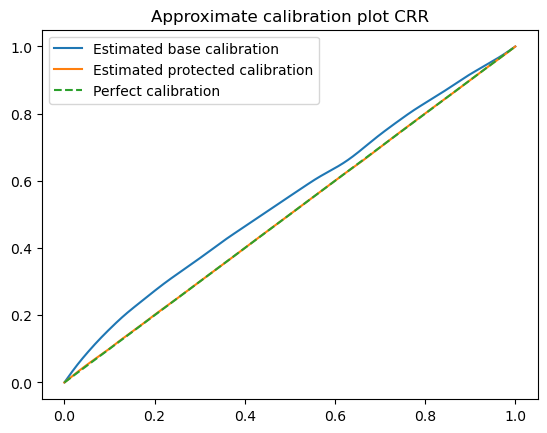

In [52]:
calibration_martingale = PluginMartingale(warnings=False) 
for p in protected_p_values:
    calibration_martingale.update_martingale_value(p)

plt.plot(
    np.linspace(0, 1, 1000),
    martingale.B_n(np.linspace(0, 1, 1000)),
    label='Estimated base calibration'
)
plt.plot(
    np.linspace(0, 1, 1000),
    calibration_martingale.B_n(np.linspace(0, 1, 1000)),
    label='Estimated protected calibration'
)
plt.plot(
    np.linspace(0, 1, 1000),
    np.linspace(0, 1, 1000),
    linestyle='--',
    label='Perfect calibration'
)
plt.legend()
plt.title('Approximate calibration plot CRR')

In [53]:
martingale.B_n(epsilon), calibration_martingale.B_n(epsilon), eps

(0.15851271575213977, 0.1006554831530071, 0.052127659574461666)

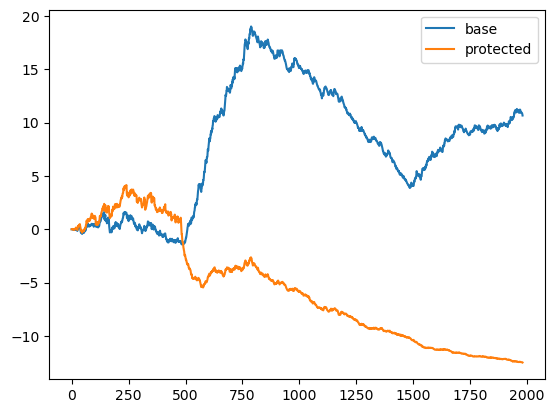

In [54]:
plt.plot(martingale.log10_martingale_values, label='base')
plt.plot(calibration_martingale.log10_martingale_values, label='protected')
plt.legend()

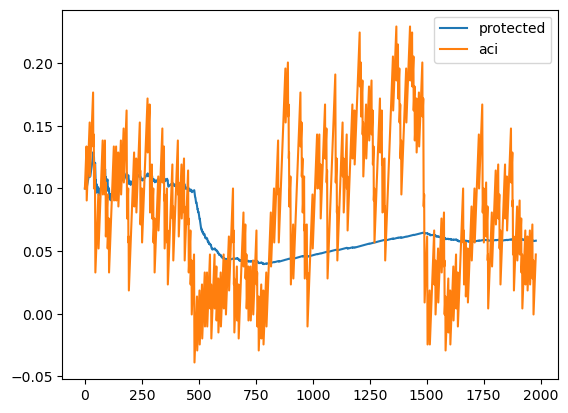

In [55]:
plt.plot(epsilon_hat_array, label='protected')
plt.plot(eps_array, label='aci')
plt.legend()

In [56]:
epsilon_hat_array.max() - epsilon_hat_array.min(), eps_array.max() - eps_array.min()

(0.08941365028689452, 0.268085106382976)

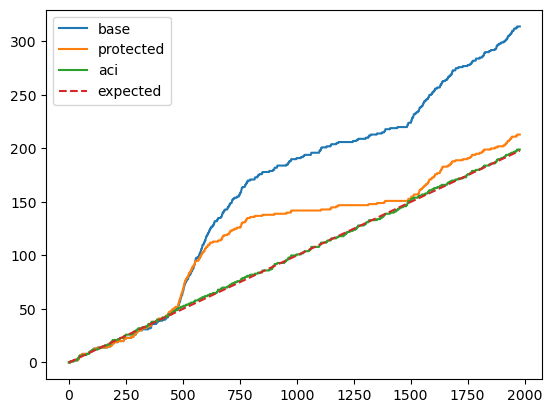

In [57]:
plt.plot(np.cumsum(((base_predictions[:,0] > y_process) + (base_predictions[:, 1] < y_process)).astype(int)), label='base')
plt.plot(np.cumsum(((protected_predictions[:,0] > y_process) + (protected_predictions[:, 1] < y_process)).astype(int)), label='protected')
plt.plot(np.cumsum(((aci_predictions[:,0] > y_process) + (aci_predictions[:, 1] < y_process)).astype(int)), label='aci')
plt.plot(epsilon*np.array([i for i,_ in enumerate(y_process)]), label='expected', linestyle='--')
plt.legend()

In [58]:
def compute_Err(p_values, epsilon):
    return (p_values <= epsilon).mean()

eps = epsilon

delta = 0.01
M = p_values.size
gamma_opt = (max(epsilon, 1-epsilon))/(delta*M - 1)
gamma = gamma_opt
gamma = 0.05
err = 0

Epsilon = np.array([i/1000 for i in range(1000)])
calibration_array = np.zeros(shape=(Epsilon.size, 3))
for i, epsilon in tqdm(enumerate(Epsilon), total=Epsilon.size):
    calibration_array[i, 0] = compute_Err(p_values, epsilon)
    calibration_array[i, 1] = compute_Err(protected_p_values, epsilon)
    
    # aci_p_values_loop = np.zeros_like(p_values)
    # for j, p in enumerate(p_values):
    #     aci_inv = lambda x: (x - eps + gamma*err) / gamma
    #     aci_p = aci_inv(p)
    #     err = int(aci_p <= eps)
    #     eps += gamma*(epsilon - err)
    #     aci_p_values_loop[j] = aci_p

    # calibration_array[i, 2] = compute_Err(aci_p_values_loop, epsilon)
    


  0%|          | 0/1000 [00:00<?, ?it/s]

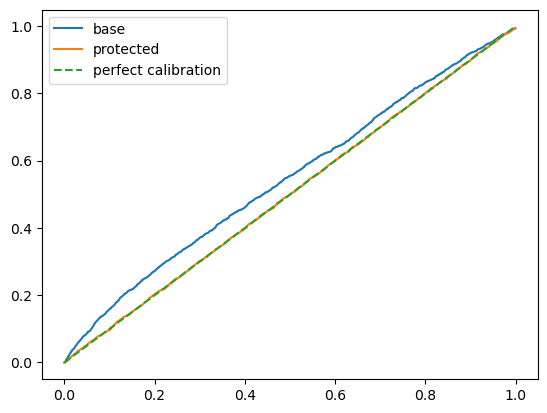

In [59]:
plt.plot(
    Epsilon, 
    calibration_array[:, 0],
    label='base'
)
plt.plot(
    Epsilon, 
    calibration_array[:, 1],
    label='protected'
)
plt.plot(
    Epsilon,
    Epsilon,
    label='perfect calibration',
    linestyle='--'
)
plt.legend()

In [60]:
winkler(base_predictions, y_process, epsilon).sum(), winkler(protected_predictions, y_process, epsilon).sum()

(12380.576587631487, 14180.401386999023)

/tmp/ipykernel_1741006/2454829930.py:17: RuntimeWarning: invalid value encountered in add
  width + (2 / alpha) * below,
/tmp/ipykernel_1741006/2454829930.py:20: RuntimeWarning: invalid value encountered in add
  width + (2 / alpha) * above,


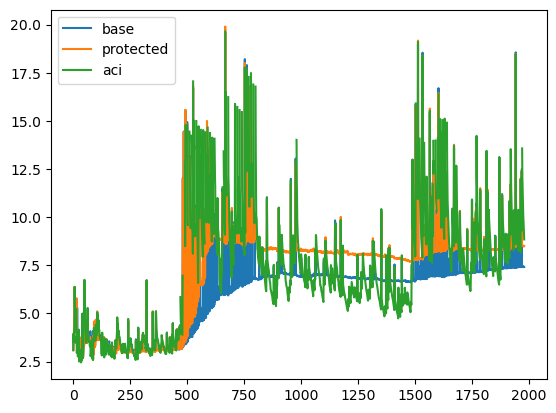

In [61]:
plt.plot(winkler(base_predictions, y_process, epsilon), label='base')

plt.plot(winkler(protected_predictions, y_process, epsilon), label='protected')

plt.plot(winkler(aci_predictions, y_process, epsilon), label='aci')

plt.legend()